# Monitoring Twitter activity for R and Python  


In [239]:
#import all Python librearies which will be used
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler 
from tweepy import Stream
import sys
import json 
import pandas as pd 
from pandas import Series, DataFrame
import re
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
import dateutil
from datetime import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns
from matplotlib import gridspec

# Data collection with Tweepy

In [ ]:
#redirection of output to the "tweetos.txt" file 
sys.stdout = open('tweetos.txt','w')

#var containing my credentials to access Twitter API
access_token = "350901312-QPAW931qOxfqzzZ7g6Na1rI7KVSNhwkJUEexmZLB"
access_token_secret = "UWPd6Untbl80tHD0ciPoi60RgsyfRd3nNiRDYE7FrR01x"
consumer_key ="KZ0Lxz7HZKXIbIYOYUUkjU5LL"
consumer_secret = "dHpePcR6dShY0XuNfoHDeM12fA7jMNUodD0QPAICbKj8i9JDIR"

#listener printing received tweets to stdout
class StdOutListener(StreamListener):
    def on_data(self,data):
        print data 
        return True
                    
    def on_error(self,status):
        print status
        
if __name__ == '__main__':
    #Twitter authentification and connection to the Twitter Streaming API 
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    
    stream = Stream(auth,l)    
    #filtering Twitter Streams with keyword 'python' and relevant keyword for R 
    stream.filter(track=['python','#rstats','@RStatsJobs','@Rstats4Econ','rlang'])


# Data Processing

In [ ]:
#read our tweets 
tweets_path = "./tweetos.txt"
tweets = []
tweets_file = open(tweets_path,'r')
for tweet_line in tweets_file: 
    try: 
        tweet = json.loads(tweet_line)
        tweets.append(tweet)
    except: 
        continue
        
#structure data tweets as panda dataframes
tweetsDF = DataFrame()

#adding columns about text, lang and country 
tweetsDF['text'] = map(lambda tweet:tweet["text"] if 'text' in tweet else 'None', tweets)
tweetsDF['lang'] = map(lambda tweet: tweet['lang'] if 'lang' in tweet else 'None', tweets)
tweetsDF['country'] = map(lambda tweet: tweet['user']['location'] if 'user' in tweet else 'None', tweets)
tweetsDF["created_at"] = map(lambda tweet: tweet["created_at"] if "created_at" in tweet else 'None', tweets)

    

# Data Cleansing - Filtering the tweets

In [2]:
#check if a word (e.g., python) is in our tweet
##or browse the whole list, if the word is found return true otherwise false
def word_in_text(words,text):
    for word in words: 
        word = word.lower()
        text = text.lower()
        if re.search(word,text):
            return True 
    return False
    
#add column 
tweetsDF['Python'] = tweetsDF['text'].apply(lambda tweet: word_in_text(['python'],tweet))
tweetsDF['R'] = tweetsDF['text'].apply(lambda tweet: word_in_text([r'R vs(.*)','#rstats','@RStatsJobs','@Rstats4Econ','rlang'],tweet))

#filter for relevant tweets, because "Monthy Python", "Gator eats python", ...
#we decide to search for words like "programming', apps', 'tutorial', ...
tweetsDF['Programming related'] = tweetsDF['text'].apply(lambda tweet: word_in_text(['kdnuggets',r'programm(.*)',r'tutorial(.*)',r'app(.*)'],tweet))

tweetsDF.head()

,text,lang,country,created_at,Python,R,Programming related
0,RT @johnhubner: #Python Programmer is out! htt...,en,"Brighton & Hove, UK",Sun Nov 08 16:05:17 +0000 2015,True,False,True
1,RT aidotech: RT kdnuggets: 500 #DeepLearning P...,en,phoenix,Sun Nov 08 16:05:17 +0000 2015,True,False,True
2,"RT kdnuggets: 500 #DeepLearning Papers, Graphv...",en,phoenix,Sun Nov 08 16:05:19 +0000 2015,True,False,True
3,RT @dataiku: R vs Python for Data Science: The...,en,San Francisco,Sun Nov 08 16:05:23 +0000 2015,True,True,True
4,Harmony Safari Park Python Encounter https://t...,et,"San Diego, CA",Sun Nov 08 16:05:25 +0000 2015,True,False,False


In [3]:
#filtering tweets only about Python programming language
tweetsDF['PythonProg'] = tweetsDF['Python'] & tweetsDF['Programming related'] 

# Bar chart of number of categorised tweets 

In [143]:
#count of tweets about R, python, ...
counts_list = []
counts_list.append(len(tweetsDF))
counts_list.append(tweetsDF['PythonProg'].value_counts()[True])
counts_list.append(tweetsDF['R'].value_counts()[True])

In [268]:
x=['Unrelated','Python','R']
y=counts_list
trace = go.Bar(
    x=x,
    y=y,
   
    marker=dict(
        color= ['grey','#FFA300','#4099FF'],
        line=dict(
            color='black',
            width=1.5,
        )
    ),
    opacity=0.9,
    text = ["None", pythondb, Rdb]
)
data = [trace]
layout = go.Layout(
      annotations=[
        dict(
            x=xi,
            y=yi,
            text=str(yi) + " tweets",
            xanchor='center',
            yanchor='bottom',
            showarrow=False,
        ) for xi, yi in zip(x, y)],

    title='Number of tweets per language from 8/11/2015 to 10/11/2015',
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='text-hover-bar')



In [4]:
#removing Python and Programming related columns as we now have the relevant insight to compare R against Python
del tweetsDF['Python']
del tweetsDF['Programming related']

In [5]:
tweetsDF.head()

,text,lang,country,created_at,R,PythonProg
0,RT @johnhubner: #Python Programmer is out! htt...,en,"Brighton & Hove, UK",Sun Nov 08 16:05:17 +0000 2015,False,True
1,RT aidotech: RT kdnuggets: 500 #DeepLearning P...,en,phoenix,Sun Nov 08 16:05:17 +0000 2015,False,True
2,"RT kdnuggets: 500 #DeepLearning Papers, Graphv...",en,phoenix,Sun Nov 08 16:05:19 +0000 2015,False,True
3,RT @dataiku: R vs Python for Data Science: The...,en,San Francisco,Sun Nov 08 16:05:23 +0000 2015,True,True
4,Harmony Safari Park Python Encounter https://t...,et,"San Diego, CA",Sun Nov 08 16:05:25 +0000 2015,False,False


# Data import and processing of our files from Refine

In [6]:
#function to read and parse our excel files from dbpedia 
def parseDBpedia(excelFile,excelSheet):
    #import xlss from the DBpedia study
    #read file and parse sheet
    Rdbxlsx = pd.ExcelFile(excelFile)
    Rdb = Rdbxlsx.parse(excelSheet)
    #combine all paradigms cells into one
    lista =[]
    for word in range(1,len(Rdb)):
        lista.append(Rdb["para"][word])
    paradigm = " | ".join(lista)
    Rdb["para"] = paradigm
    #get read of duplicates
    del Rdb["lang"]
    RDf = Rdb.ix[[0]]
    #allocate relevant names to columns
    RDf.columns = ['Language', 'Paradigms','OS','License']
    return RDf

#get our dataframes and concatenate them
RDF = parseDBpedia("sparql-csv (1).xls","sparql csv")
pythonDF = parseDBpedia("sparql-csv.xls","sparql csv")
RDF["Language"][0] = 'R'
DF = pd.concat([pythonDF,RDF])
DF = DF.reset_index(drop=True)

In [7]:
#merge DF and 
tweetsDF.loc[ tweetsDF.R==True,'R'] = 'R'
tweetsDF.loc[ tweetsDF.PythonProg==True,'PythonProg'] = 'Python'

In [141]:
pythondb = "Insights for Python: <br>" + "Paradigms: " + DF.ix[0]["Paradigms"] + "<br>OS: " + DF.ix[0]["OS"] + "<br>License: "+DF.ix[0]["License"]
Rdb = "Insights for R: <br>" + "Paradigms: " + DF.ix[1]["Paradigms"] + "<br>OS: " + DF.ix[1]["OS"] + "<br>License: "+DF.ix[1]["License"]

In [133]:
DF

,Language,Paradigms,OS,License
Python,Python,Functional_programming | Procedural_programmin...,Cross-platform,Python_Software_Foundation_License
R,R,Functional_programming | Procedural_programmin...,Cross-platform,GNU_General_Public_License


In [8]:
df = tweetsDF.loc[(tweetsDF.R != False) & (tweetsDF.PythonProg != False),:]

In [9]:
#create new column Programming Language
ser1=tweetsDF["R"]
ser2=tweetsDF["PythonProg"]
langage = Series(np.where(ser1==False,ser2,ser1),index = ser1.index)
tweetsDF["Language"] = langage


In [10]:
del tweetsDF["R"]
del tweetsDF["PythonProg"]

In [11]:
#rename indexes
DF.rename(index={0:'Python',1:'R'},inplace=True)

In [53]:
#merge dataframes on DF indexes for tweetsDF Language column 
mergedDF = pd.merge(tweetsDF,DF,left_on='Language',right_index=True)
del mergedDF["Language_y"]
del mergedDF["Language_x"]
mergedDF.head()

,Language,text,lang,country,created_at,Paradigms,OS,License
0,Python,RT @johnhubner: #Python Programmer is out! htt...,en,"Brighton & Hove, UK",Sun Nov 08 16:05:17 +0000 2015,Functional_programming | Procedural_programmin...,Cross-platform,Python_Software_Foundation_License
1,Python,RT aidotech: RT kdnuggets: 500 #DeepLearning P...,en,phoenix,Sun Nov 08 16:05:17 +0000 2015,Functional_programming | Procedural_programmin...,Cross-platform,Python_Software_Foundation_License
2,Python,"RT kdnuggets: 500 #DeepLearning Papers, Graphv...",en,phoenix,Sun Nov 08 16:05:19 +0000 2015,Functional_programming | Procedural_programmin...,Cross-platform,Python_Software_Foundation_License
6,Python,RT @reubenbond: Most JS/Python/Ruby apps... ht...,en,☑ hype-ass lyrics ☑ dope beats,Sun Nov 08 16:05:46 +0000 2015,Functional_programming | Procedural_programmin...,Cross-platform,Python_Software_Foundation_License
7,Python,#Kivy.org Kivy – Interactive Applications and ...,en,Cartagena-Madrid,Sun Nov 08 16:05:50 +0000 2015,Functional_programming | Procedural_programmin...,Cross-platform,Python_Software_Foundation_License


In [54]:
#convert Twitter time to date format 
mergedDF['created_at'] = mergedDF['created_at'].apply(lambda created_at: datetime.strptime(created_at, "%a %b %d %H:%M:%S +0000 %Y") ,created_at)


In [161]:
del mergedDF["Python_Counts"]

# Heatmaps using Seaborn to show frequency of tweets for each language per day per hour

In [146]:
"added come columns contaning day and hour for each tweets to make it easier to play with data"
mergedDF["Day"] = mergedDF['created_at'].apply(lambda d: d.day)
mergedDF["Hour"] = mergedDF['created_at'].apply(lambda d: d.hour)

In [149]:
rfilter = mergedDF.loc[mergedDF["Language"]=="R"]
pythonfilter = mergedDF.loc[mergedDF["Language"]=="Python"]

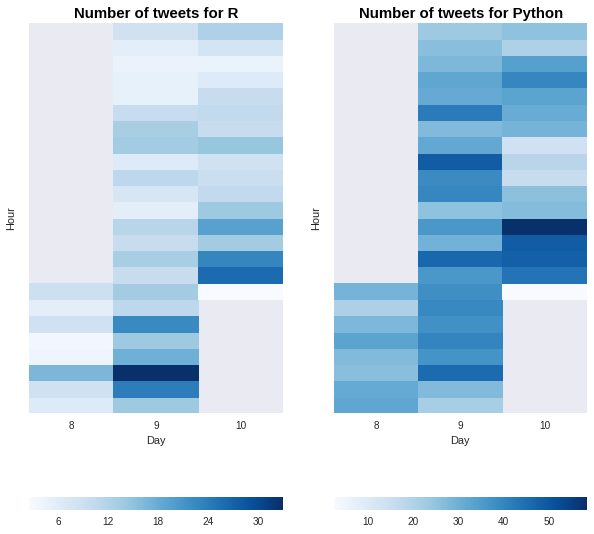

In [178]:
fig = plt.figure(figsize=(10, 10)) 
ax1 = plt.subplot(121)
ax1.set_title("Number of tweets for R",fontsize=15, fontweight='bold',color="black")
rpivot = pd.pivot_table(rfilter,values='Counts',index='Hour',columns='Day')
sns.heatmap(rpivot, yticklabels=False,cmap='Blues',cbar_kws={"orientation": "horizontal"})
ax2 = plt.subplot(122)
ax2.set_title("Number of tweets for Python",fontsize=15, fontweight='bold',color="black")
pythonpivot = pd.pivot_table(pythonfilter,values='Counts',index='Hour',columns='Day')
sns.heatmap(pythonpivot, yticklabels=False,cmap='Blues',cbar_kws={"orientation": "horizontal"})
plt.show()


In [69]:
mergedDF["Counts"] = Series(mergedDF.groupby(["Language",mergedDF["created_at"].map(lambda d: d.day),mergedDF["created_at"].map(lambda d: d.hour)]).cumcount() + 1)

In [189]:
xs = Series(mergedDF["Counts"].groupby([mergedDF["Language"],mergedDF["created_at"].map(lambda d: d.day),mergedDF["created_at"].map(lambda d: d.hour)]).max())

# Line chart about Twitter activity for R and Python 

In [251]:
mergedDF = mergedDF.reset_index(drop=True)
#get the max counts, i.e. number of tweets per day per hour 
rmax = Series(rfilter["Counts"].groupby([rfilter["created_at"].map(lambda d: d.day),rfilter["created_at"].map(lambda d: d.hour)]).max())
rfilter = rfilter.reset_index(drop=True)
pythonmax = Series(pythonfilter["Counts"].groupby([pythonfilter["created_at"].map(lambda d: d.day),pythonfilter["created_at"].map(lambda d: d.hour)]).max())
pythonfilter = pythonfilter.reset_index(drop=True)
rmax = rmax.tolist()
pythonmax = pythonmax.tolist()

#we want to retieve max tweet value / hour /day for each language along with the created_at date
def get_date_of_max(df,dfmax):
    store_date = []
    j=0
    for i in range(0, len(df)):
        if (df.ix[i]["Counts"] == dfmax[j]):
            store_date.append(df.ix[i]["created_at"])
            j = j+1
        else: 
            continue
    return store_date
y1 = rmax
y2 = pythonmax
ylist = y1 + y2 

In [252]:
len(ylist)

98

In [266]:
x1 = get_date_of_max(rfilter,rmax)
y1 = rmax
x2 = get_date_of_max(pythonfilter,pythonmax)
y2 = pythonmax
ylist = []
ylist.append(y1)
ylist.append(y2)
# Create a trace
trace1 = go.Scatter(
    x = x1,
    y = y1,
    name="Tweets about R",
    line = dict(
        color = '#4099FF',
              
    )
)

trace2 = go.Scatter(
    x = x2,
    y = y2,
    name="Tweets about Python",
    line = dict(
        color = '#FFA300',
              
    )
)

# Edit the layout

layout = go.Layout(dict(title = 'Tweeter activity for R and Python',
              xaxis = dict(title = 'Date of creation of the tweet'),
              yaxis = dict(title = 'Number of Tweets Per hour'),
              
             )
        )
            

# Plot and embed in ipython notebook!
data = [trace1,trace2]
fig = dict(data=data, layout=layout)
# Plot and embed in ipython notebook!
py.iplot(fig, filename='basic-line')
